# GSOC 2020 DeepLens Project Task-II Solution


Name: K Pranath Reddy

Email: pranath.mail@gmail.com, f20160572@hyderabad.bits-pilani.ac.in
        
Link to my CV: https://drive.google.com/file/d/1G-8YjE_0qPpJa88vHllIz1qUvNjxnnC-/view?usp=sharing&authuser=0

My GitHub Profile: github.com/PyJedi (All my ongoing projects are in private repositories)

## Task II. Learning the DM representation



**Description:** A set of simulated strong gravitational lensing images with and without substructure.

**Task:** Using a deep learning algorithm of your choice learn the representation of dark matter in the strong gravitational lensing images provided using PyTorch.
The goal is to use this learned representation for anomaly detection, hence you should pick the most appropriate algorithm and discuss your strategy.

### Solution:

**Deep Convolutional AutoEncoder based CNN Classifier**

For this task i will be using a deep convolutional autoencoder for feature extraction of the lensing images and then use the learned representations for classification or anomaly detection. I have implemented the Deep Convolutional AutoEncoder (DCA) in PyTorch and the CNN classifier in Keras.

**Proposed Methodology:**


![Methodology](Method.png)


**Architecture of the DCA model:**


![Architecture of DCA model](DCA.png)


**Architecture of the CNN model:**


![Architecture of CNN model](CNN.png)

I have used hold-out cross validation with 80/20 split to evaluate the performance of the CNN model and found the accuracy to be **95%** and the macro–averaged Area under the ROC curve to be **0.98756** 


### Data:


In [1]:
#Saving the lensing data into numpy arrays

import cv2
import os
import numpy as np

mypath = './lenses/sub'
files = [os.path.join(mypath, f) for f in os.listdir(mypath) if f.endswith(".jpg")]

sub = []
for images in files:

    img = cv2.imread(images,0)
    sub.append(img)
    
sub = np.asarray(sub)
print(sub.shape)
np.save('sub_data',sub)

mypath = './lenses/no_sub'
files = [os.path.join(mypath, f) for f in os.listdir(mypath) if f.endswith(".jpg")]

no_sub = []
for images in files:

    img = cv2.imread(images,0)
    no_sub.append(img)
    
no_sub = np.asarray(no_sub)
print(no_sub.shape)
np.save('no_sub_data',no_sub)

(5000, 150, 150)
(5000, 150, 150)


### Training DCA:

### DCA for lensing images with substructure: (DCA-1)

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

train_data = np.load('sub_data.npy')
train_data = train_data.reshape(-1,1,150,150)
train_data = train_data.astype(np.float32)
print(train_data.shape)

# Build the Model
class DCA(nn.Module):
    def __init__(self):
        super(DCA, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((71,71), stride=1),
            nn.Conv2d(32, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((31,31), stride=1),
            nn.Conv2d(16, 8, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((11,11), stride=1),
            nn.Flatten(),
            nn.Linear(800, 800),
            nn.BatchNorm1d(800),
            nn.Linear(800, 500),
            nn.BatchNorm1d(500),
            nn.Linear(500, 800),
            nn.BatchNorm1d(800)
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(8, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, (11,11), stride=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1,8,10,10)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DCA().to(device)

num_workers = 0
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 300

loss_array = []
# Start training
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data in train_loader:

        #images, _ = data
        data = data.cuda()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criteria(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    loss_array.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))
    torch.save(model, 'DCA_Sub.pth')
    np.save('loss_sub', np.asarray(loss_array))

### DCA for lensing images without substructure: (DCA-2)

In [ ]:
train_data = np.load('no_sub_data.npy')
train_data = train_data.reshape(-1,1,150,150)
train_data = train_data.astype(np.float32)
print(train_data.shape)

# Build the Model
class DCA(nn.Module):
    def __init__(self):
        super(DCA, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((71,71), stride=1),
            nn.Conv2d(32, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((31,31), stride=1),
            nn.Conv2d(16, 8, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((11,11), stride=1),
            nn.Flatten(),
            nn.Linear(800, 800),
            nn.BatchNorm1d(800),
            nn.Linear(800, 500),
            nn.BatchNorm1d(500),
            nn.Linear(500, 800),
            nn.BatchNorm1d(800)
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(8, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, (11,11), stride=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1,8,10,10)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DCA().to(device)

num_workers = 0
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 300

loss_array = []
# Start training
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data in train_loader:

        #images, _ = data
        data = data.cuda()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criteria(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    loss_array.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))
    torch.save(model, 'DCA_No_Sub.pth')
    np.save('loss_no_sub', np.asarray(loss_array))

### Loss convergence of DCA models:

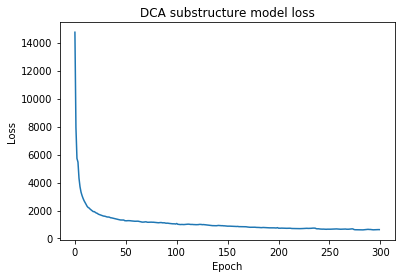

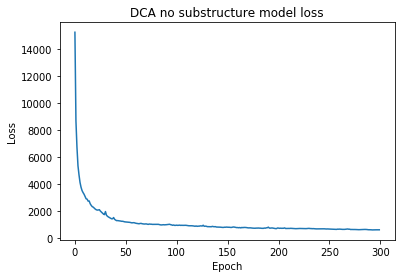

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_sub = np.load('loss_sub.npy')
loss_no_sub = np.load('loss_no_sub.npy')

plt.plot(loss_sub)
plt.title('DCA substructure model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(loss_no_sub)
plt.title('DCA no substructure model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Feature Extraction:

Feature extraction of substructure and non substructure lensing images using the trained models

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable

# Select the training data
#train_data = np.load('sub_data.npy')
#train_data = np.load('no_sub_data.npy')

train_data = train_data.reshape(-1,1,150,150)
train_data = train_data.astype(np.float32)
print(train_data.shape)

# Build the Model
class DCA(nn.Module):
    def __init__(self):
        super(DCA, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((71,71), stride=1),
            nn.Conv2d(32, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((31,31), stride=1),
            nn.Conv2d(16, 8, (11,11), stride=1),
            nn.ReLU(True),
            nn.AvgPool2d((11,11), stride=1),
            nn.Flatten(),
            nn.Linear(800, 800),
            nn.BatchNorm1d(800),
            nn.Linear(800, 500),
            nn.BatchNorm1d(500),
            nn.Linear(500, 800),
            nn.BatchNorm1d(800)
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(8, 16, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 32, (11,11), stride=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, (11,11), stride=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1,8,10,10)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DCA().to(device)

# Select the Model
#model = torch.load('DCA_Sub.pth')
#model = torch.load('DCA_No_Sub.pth')

summary(model, (1,150, 150))
features = model.encoder[:13]

out = []
num_workers = 0
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
i = 0
for data in train_loader:
  i = i + 1
  data = data.cuda()
  out.append(features(data).cpu().detach().numpy())

out = np.asarray(out)
out = out.reshape(-1,1,500)
print(out.shape)

# Save the features corresponding to each model and dataset
#np.save('DCA_features_sub.npy',out)
#np.save('DCA_features_no_sub.npy',out)
#np.save('DCA2_features_sub.npy',out)
#np.save('DCA2_features_no_sub.npy',out)

### Combine the features:

In [5]:
dca_sub = np.load('DCA_features_sub.npy')
dca_no_sub = np.load('DCA_features_no_sub.npy')
dca2_sub = np.load('DCA2_features_sub.npy')
dca2_no_sub = np.load('DCA2_features_no_sub.npy')

sub = np.concatenate((dca_sub, dca2_sub), axis=2)
no_sub = np.concatenate((dca_no_sub, dca2_no_sub), axis=2)

print(sub.shape)
print(no_sub.shape)

np.save('sub_features.npy', sub)
np.save('no_sub_features.npy', no_sub)

(5000, 1, 1000)
(5000, 1, 1000)


### CNN Model:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 498, 32)           192       
_________________________________________________________________
average_pooling1d (AveragePo (None, 249, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 123, 16)           2576      
_________________________________________________________________
average_pooling1d_1 (Average (None, 62, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 992)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               198600    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4

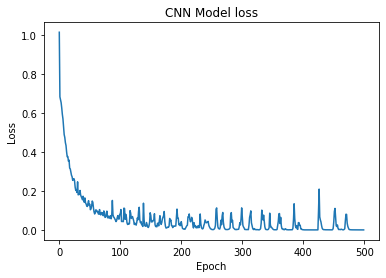

Model Saved

Confusion Matrix: 
Predicted    0    1
Actual             
0          955   40
1           58  947

Report: 
              precision    recall  f1-score   support

      no sub       0.94      0.96      0.95       995
         sub       0.96      0.94      0.95      1005

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


macro–averaged Area under the ROC curve:
0.9875596889922248


In [6]:
import tensorflow as  tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional,Conv1D,AveragePooling1D,Flatten
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score

sub = np.load('sub_features.npy')
no_sub = np.load('no_sub_features.npy')
x = np.concatenate((sub, no_sub), axis=0)
y = np.append(np.ones((5000,), dtype=int), np.zeros((5000,), dtype=int))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# adjust dimensions
x_train = x_train.reshape(-1,1000,1)
x_test = x_test.reshape(-1,1000,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# bulid model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=(5), input_shape=(1000,1), strides=2, padding='valid', activation='relu'))
model.add(AveragePooling1D(pool_size=2,strides=2,padding='same'))
model.add(Conv1D(filters=16, kernel_size=(5), strides=2, padding='valid', activation='relu'))
model.add(AveragePooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(2,activation='softmax'))

opt = optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=500, verbose=0)
model.summary()

plt.plot(model_history.history['loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

model.save("CNN_Model.h5")
print('Model Saved')
print('')

# testing the model
yp = model.predict(x_test)
yp2 = model.predict_classes(x_test)
y_test = np.asmatrix(y_test)
y_test = y_test.T
y_test = np.asarray(y_test)

y_actual = pd.Series(y_test[0], name='Actual')
y_pred = pd.Series(yp2, name='Predicted')
confmat = pd.crosstab(y_actual, y_pred)

print('Confusion Matrix: ')
print(confmat)
print('')

y_prob = model.predict_proba(x_test)
y_test = y_test.reshape(-1,1)

print('Report: ')
target_names = ['no sub', 'sub']
print(classification_report(y_actual, y_pred, target_names=target_names))
print('')

print('macro–averaged Area under the ROC curve:')
auroc = roc_auc_score(y_test, y_prob[:,-1])
print(auroc)